In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import os
import re

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

from langdetect import detect

In [2]:
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}

def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    for labelid in classlabel:
        feature_names = vectorizer.get_feature_names_out()
        top_n = sorted(zip(classifier.feature_log_prob_[labelid], feature_names), reverse=True)[:n]
        for coef, feat in top_n:
            print("SDG {} : {:30}  {:.6}".format(labelid, feat, coef))
        print("")
def print_top_n_features(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top_n = np.argsort(clf.feature_log_prob_[i])[::-1][:n]
        print("%s: %s" % (class_label,
              " || ".join(feature_names[j] for j in top_n)))

In [3]:
text_df = pd.read_csv("/Users/yingli/Downloads/osdg-community-data-v2023-01-01.csv", sep = "\t", quotechar='"')
col_names = text_df.columns.values[0].split('\t')
text_df[col_names] = text_df[text_df.columns.values[0]].apply(lambda x: pd.Series(str(x).split("\t")))
text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
text_df = text_df.astype({'sdg':int, 'labels_negative': int, 'labels_positive':int, 'agreement': float}, copy=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2")
text_df.reset_index(drop=True, inplace=True)

### use sklearn make_pipeline
 - the api doc says it works with sklearn estimators, probably not work with other estimators

In [4]:
select_sdg = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
docs = text_df.query("sdg in @select_sdg").text
categories = text_df.query("sdg in @select_sdg").sdg
X_train, X_test, y_train, y_test = train_test_split(
    docs, categories, test_size=0.33, random_state=7)

par = [CountVectorizer(ngram_range=(1,1),stop_words='english')]

model = make_pipeline(CountVectorizer(ngram_range=(2,2), stop_words = "english" ),\
            MultinomialNB())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.7223    0.8274    0.7713       481
           2     0.8475    0.7563    0.7993       316
           3     0.8926    0.9243    0.9082       674
           4     0.8338    0.9479    0.8872       863
           5     0.7570    0.9380    0.8379       920
           6     0.8653    0.8839    0.8745       465
           7     0.7469    0.9096    0.8203       730
           8     0.8125    0.3314    0.4708       353
           9     0.8497    0.5000    0.6296       328
          10     0.7970    0.4141    0.5450       256
          11     0.8383    0.7294    0.7801       462
          12     0.9098    0.5115    0.6549       217
          13     0.7243    0.8600    0.7864       443
          14     0.9171    0.6730    0.7763       263
          15     0.8987    0.6805    0.7745       313
          16     0.8860    0.9849    0.9328      1057

    accuracy                         0.8184      8141
   macro avg     0.8312   

### getting embeddings
 - setting up tensorflow and the USE embedding model
 - setting up nltk tokenizer

 - use nltk to segment document into sentences, and embed each sentence
 - or embed the document (as a short paragraph) directly

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

embed_url = "https://tfhub.dev/google/universal-sentence-encoder/4" # "https://tfhub.dev/google/universal-sentence-encoder-large/5"
embed = hub.load(embed_url) # print ("module %s loaded" % module_url)

2023-03-21 17:23:50.591849: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import nltk.data
from nltk import word_tokenize, sent_tokenize
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

 - checking it out

In [17]:
m1 = sent_tokenize(text_df.text[1])
m2 = tokenizer.tokenize(text_df.text[1]) 
print(len(m1))
print(len(m2))
m3 = embed(m1)
m4 = embed(m2)
print(m3.shape, m4.shape)
print(m3)

3
3
(3, 512) (3, 512)
tf.Tensor(
[[-0.00977661  0.01497553 -0.05236568 ...  0.01433331  0.01728721
  -0.05476953]
 [-0.04189135  0.06337392 -0.04380506 ...  0.0005867  -0.07348307
   0.01358481]
 [-0.03124038 -0.01908161  0.00046434 ...  0.03798001 -0.01439617
   0.0021454 ]], shape=(3, 512), dtype=float32)


### break all document into sentences
* repeat the SDG label of the document onto its sentences
*  [sdg]*len(sentence)

In [5]:
text_df_sentence = []
text_df_sdg = []
for (text, sdg) in iter(zip(text_df.text, text_df.sdg)):
    sentence = sent_tokenize(text) 
    text_df_sentence = text_df_sentence + sentence
    text_df_sdg = text_df_sdg + [sdg]*len(sentence)
sentence_df = pd.DataFrame({"text": text_df_sentence, "sdg": text_df_sdg})

In [6]:
text_df.shape, sentence_df.shape

((24669, 7), (92839, 2))

 - verify by doing a sentence break and sum up the length

In [7]:
text_df.text.apply(lambda x: len(sent_tokenize(x))).sum()


92839

 - almost all documents have less than 10 sentences

In [32]:
text_df["num_sent"] = text_df.text.apply(lambda x: len(sent_tokenize(x)))
text_df["num_sent"].value_counts()

3     12015
4      7579
5      2263
6      1586
2       586
7       354
8       119
1        89
9        21
10       14
12       12
13        6
15        6
11        4
14        4
16        3
17        2
18        1
24        1
31        1
21        1
19        1
20        1
Name: num_sent, dtype: int64

* use sentence_df to prepare data for classification

In [33]:
docs = sentence_df.text
categories = sentence_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(docs, categories, test_size=0.33, random_state=7)

 - build sentence level embedding
 - same if doing this before the train_test split

In [34]:
X_train_use_vector = embed(X_train.tolist())
X_test_use_vector = embed(X_test.tolist())

### using the sentence embedding vectors for classification
 - not quite making sense because the document label of SDG depend on the full document
 - individual sentences taking the document labels may introduce noises

In [35]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train_use_vector)
X_train_use_vector_scaled = scaler.transform(X_train_use_vector)
X_test_use_vector_scaled = scaler.transform(X_test_use_vector)

use_mlp_clf = MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=(300,)).fit(X_train_use_vector_scaled, y_train)
y_pred = use_mlp_clf.predict(X_test_use_vector_scaled)
print(metrics.classification_report(y_test,y_pred, digits = 4))

              precision    recall  f1-score   support

           1     0.4959    0.6366    0.5575      1794
           2     0.6177    0.5242    0.5672      1196
           3     0.8632    0.6374    0.7333      2377
           4     0.7820    0.7464    0.7638      3028
           5     0.7748    0.7024    0.7368      3296
           6     0.6733    0.6307    0.6513      1706
           7     0.6651    0.6479    0.6564      2587
           8     0.4400    0.3285    0.3762      1172
           9     0.4626    0.4678    0.4652      1165
          10     0.5819    0.2534    0.3530       967
          11     0.6471    0.5117    0.5715      1745
          12     0.6126    0.3679    0.4597       791
          13     0.5687    0.5087    0.5371      1659
          14     0.5408    0.6787    0.6020       996
          15     0.2758    0.7422    0.4022      1129
          16     0.7896    0.8584    0.8226      5029

    accuracy                         0.6412     30637
   macro avg     0.6120   

### use t-SNE to project high dimension vector into 2 D space
 - https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
 - t-SNE may take some time to run
 - t-SNE API documentation suggests scale to same scale, using MinMax scaler


In [12]:
from sklearn.manifold import TSNE
scaler = preprocessing.MinMaxScaler().fit(X_train_use_vector)
X_train_use_vector_scaled = scaler.transform(X_train_use_vector)
X_test_use_vector_scaled = scaler.transform(X_test_use_vector)

tsne = TSNE(2, verbose=0, perplexity=50)
tsne_proj = tsne.fit_transform(X_test_use_vector_scaled)

 - plot selected SDGs on 2D

/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_17516/1469998602.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_17516/1469998602.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=cmap(lab), label = lab ,alpha=0.7,s=10)


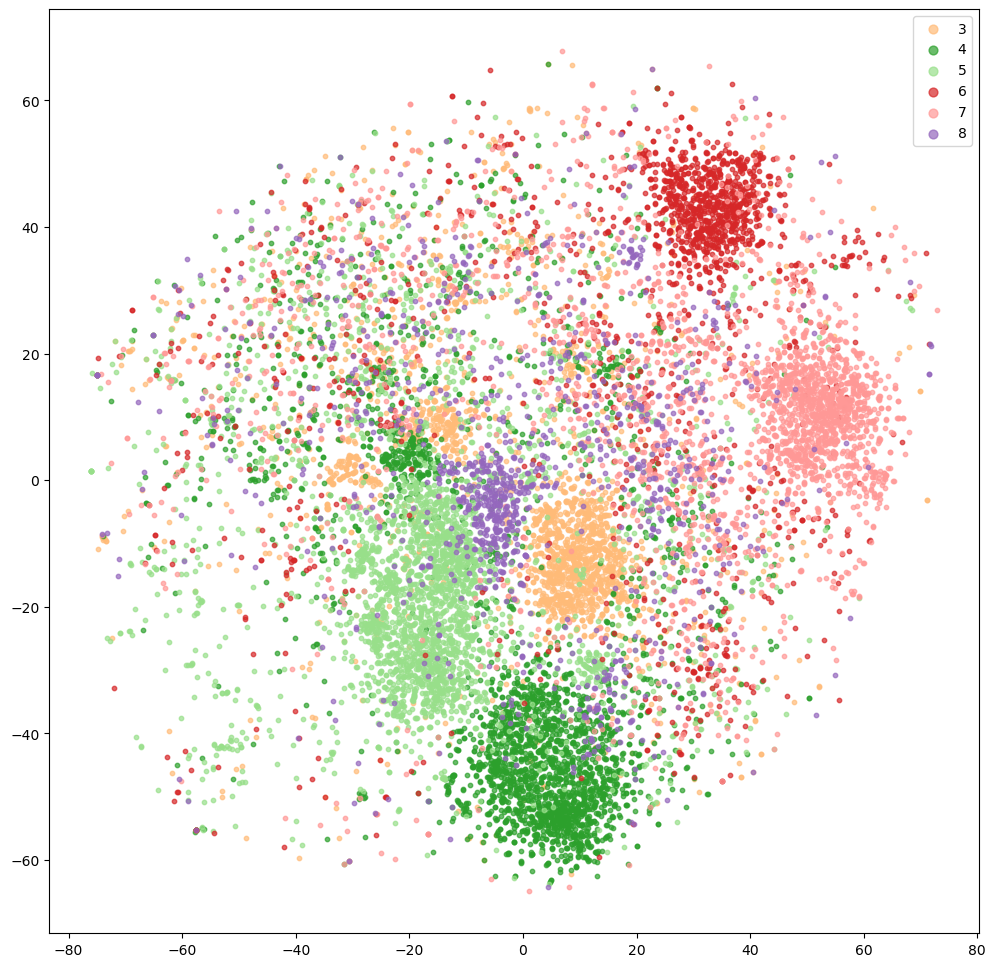

In [13]:
from matplotlib import cm
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(12,12))
num_categories = [3,4,5,6,7,8]
for lab in num_categories:
    indices = y_test==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=cmap(lab), label = lab ,alpha=0.7,s=10)
ax.legend(markerscale=2)
plt.show()

In [ ]:

num_categories = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]


* plot with y_pred class labels

/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_17516/3093093579.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_17516/3093093579.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=cmap(lab), label = lab ,alpha=0.7,s=10)


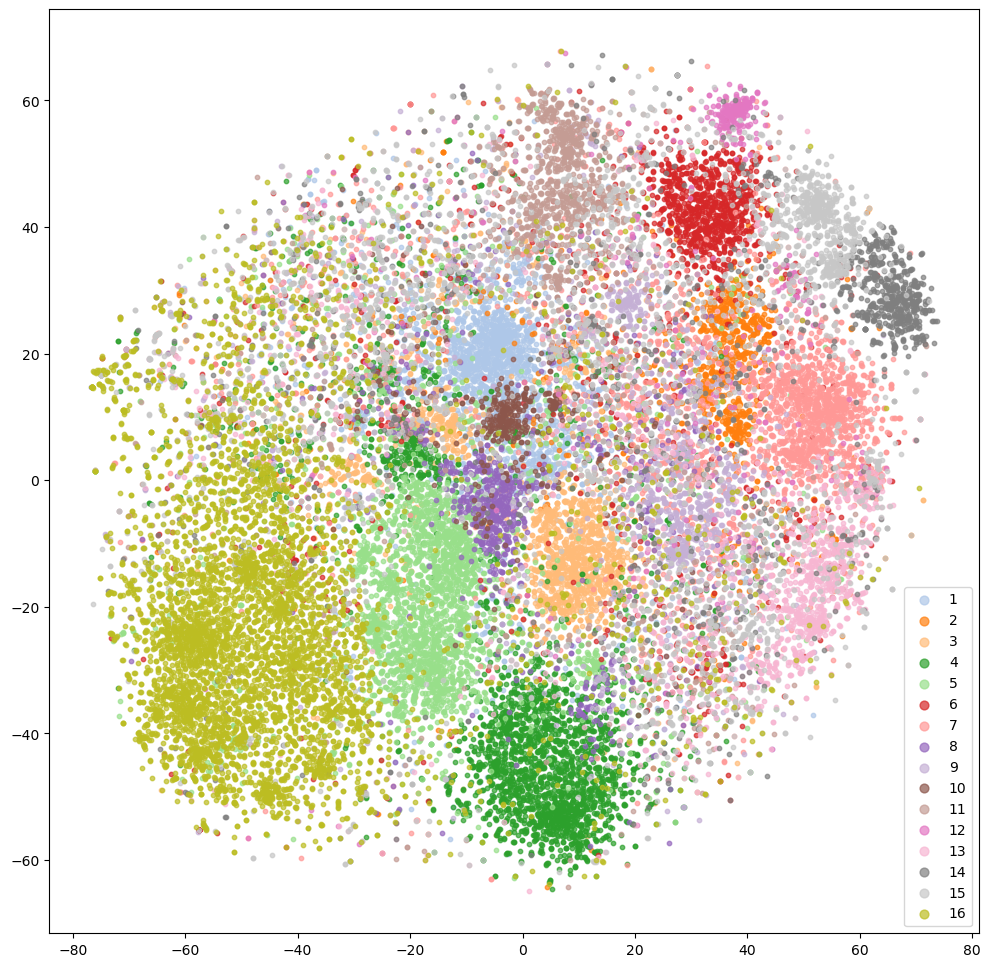

In [14]:
use_mlp_clf = MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=(300,)).fit(X_train_use_vector_scaled, y_train)
y_pred = use_mlp_clf.predict(X_test_use_vector_scaled)

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(12,12))
num_categories = [3,4,5,6,7,8]
for lab in num_categories:
    indices = y_pred==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=cmap(lab), label = lab ,alpha=0.7,s=10)
ax.legend(markerscale=2)
plt.show()


### get embedding at document level

In [36]:
docs = text_df.text
categories = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(docs, categories, test_size=0.33, random_state=7)

In [37]:
X_train_use_vector = embed(X_train.tolist())
X_test_use_vector = embed(X_test.tolist())

scaler = preprocessing.StandardScaler().fit(X_train_use_vector)
#scaler = preprocessing.MinMaxScaler().fit(X_train_use_vector)
X_train_use_vector_scaled = scaler.transform(X_train_use_vector)
X_test_use_vector_scaled = scaler.transform(X_test_use_vector)

In [39]:
for i in range(1):
    size = 300 + i*10
    use_mlp_clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(size,)).fit(X_train_use_vector_scaled, y_train)
    y_pred = use_mlp_clf.predict(X_test_use_vector_scaled)
    print("macro-averaged precision for {} = {:.4}".format(size, metrics.precision_score(y_test, y_pred, average = 'macro')))

macro-averaged precision for 120 = 0.7825
macro-averaged precision for 130 = 0.7869
macro-averaged precision for 140 = 0.7866
macro-averaged precision for 150 = 0.7833


/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_17516/2897101876.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=cmap(lab), label = lab ,alpha=0.7,s=10)


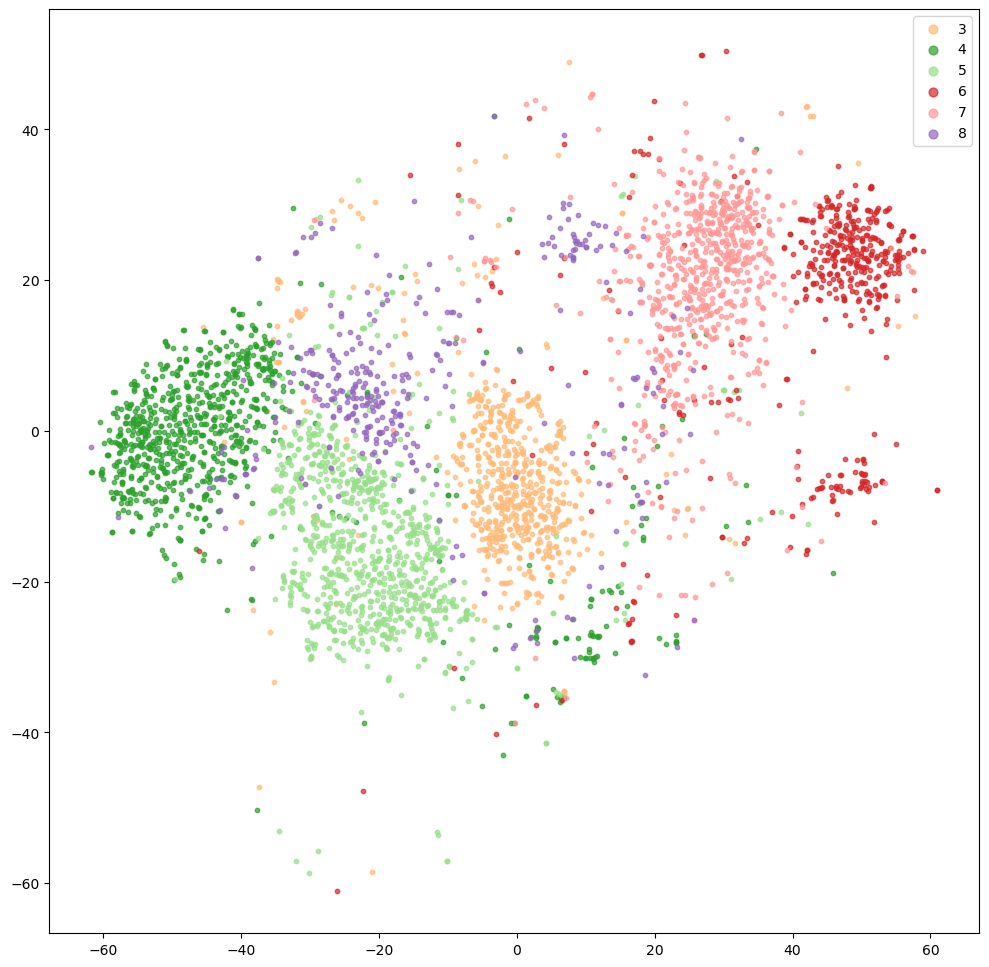

In [41]:
scaler = preprocessing.MinMaxScaler().fit(X_train_use_vector)
X_train_use_vector_scaled = scaler.transform(X_train_use_vector)
X_test_use_vector_scaled = scaler.transform(X_test_use_vector)

tsne = TSNE(2, verbose=0, perplexity=50)
tsne_proj = tsne.fit_transform(X_test_use_vector_scaled)

fig, ax = plt.subplots(figsize=(12,12))
num_categories = [3,4,5,6,7,8]
for lab in num_categories:
    indices = y_test==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=cmap(lab), label = lab ,alpha=0.7,s=10)
ax.legend(markerscale=2)
plt.show()

/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_17516/523254733.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=cmap(lab), label = lab ,alpha=0.7,s=10)


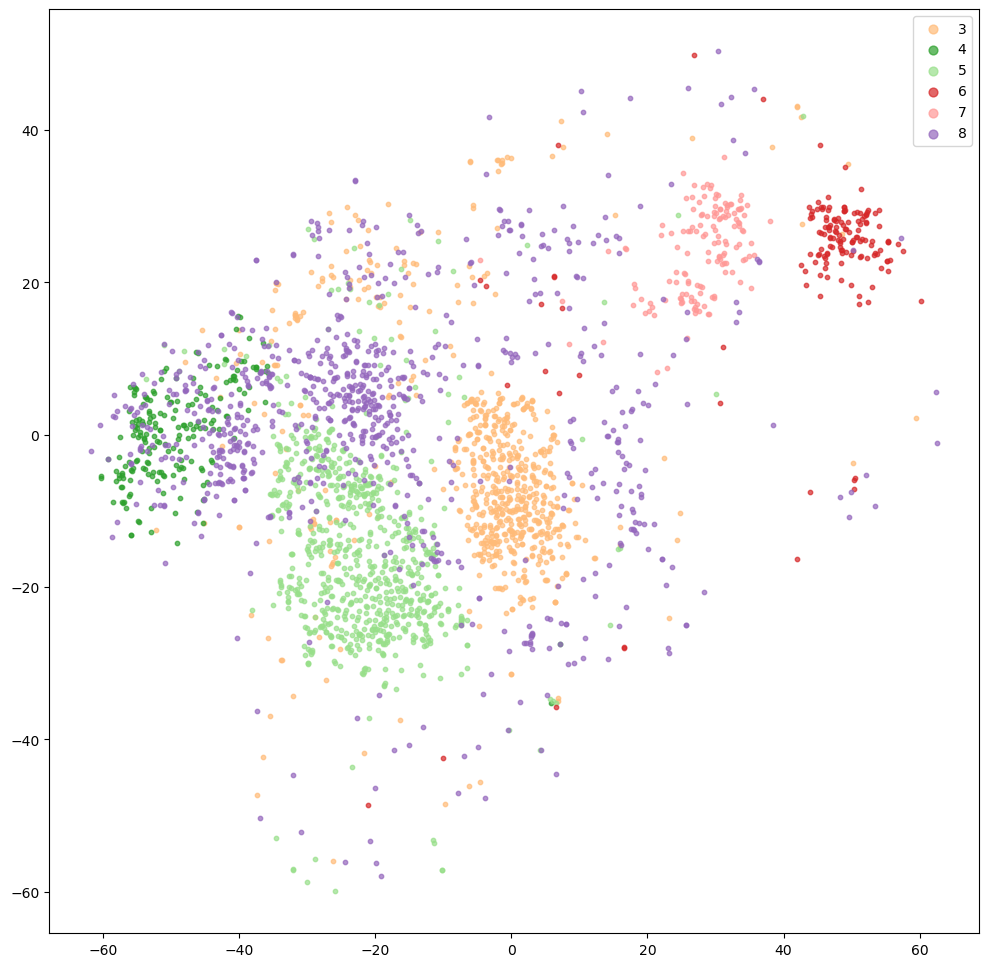

In [42]:
y_pred = use_mlp_clf.predict(X_test_use_vector_scaled)

fig, ax = plt.subplots(figsize=(12,12))

num_categories = [3,4,5,6,7,8]
for lab in num_categories:
    indices = y_pred==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=cmap(lab), label = lab ,alpha=0.7,s=10)
ax.legend(markerscale=2)
plt.show()

In [13]:
for solver in ['lbfgs', 'sgd', 'adam']:
    size = 300
    use_mlp_clf = MLPClassifier(random_state=1, max_iter=100, hidden_layer_sizes=(size,), solver = solver).fit(X_train_use_vector, y_train)
    y_pred = use_mlp_clf.predict(X_test_use_vector)
    print("macro-averaged precision for {} = {:.4}".format(solver, metrics.precision_score(y_test, y_pred, average = 'macro')))

/Users/yingli/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


macro-averaged precision for 40 = 0.7912


/Users/yingli/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yingli/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


macro-averaged precision for 40 = 0.5764
macro-averaged precision for 40 = 0.7986


/Users/yingli/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


 - classification based on document embedding
 - max_iter = 100: 0.8326
 - max_iter = 100, hidden_layer_size = (100, 70): 0.8170
 - max_iter = 100, hidden_layer = (200,): 0.7885
 - max_iter = 100, hidden_layer = 
  - 30: 0.7985
  - 40: 0.7986 
   - solver = lbfgs: 0.7912
   - sgd: 0.5764
   - adam:0.7986
  - 50: 0.7974
  - 60: 0.7945
  - 70: 0.7963
  - 80: 0.7859
  - 90: 0.7907
  - 100:0.789
  - 110: 0.7875
  - 120: 0.7869
  - 130: 0.7844
 - max_iter = 100, hidden_layer = (850,): 0.7982 
 - max_iter = 100, hidden_layer = (150,): 0.788 


In [23]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train_use_vector)
X_train_use_vector_scaled = scaler.transform(X_train_use_vector)
X_test_use_vector_scaled = scaler.transform(X_test_use_vector)

In [ ]:
#size = (300, 100, )
for size in iter(zip([300, 400, 500, 600], [200, 200, 300, 300])):
    use_mlp_clf = MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=size).fit(X_train_use_vector_scaled, y_train)
    y_pred = use_mlp_clf.predict(X_test_use_vector_scaled)
    print("macro-averaged precision for {} = {:.4}".format(size, metrics.precision_score(y_test, y_pred, average = 'macro')))

In [27]:
#size = (300, 100, )
for size in iter(zip([300, 400, 500, 600], [200, 200, 300, 300])):
    use_mlp_clf = MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=size).fit(X_train_use_vector_scaled, y_train)
    y_pred = use_mlp_clf.predict(X_test_use_vector_scaled)
    print("macro-averaged precision for {} = {:.4}".format(size, metrics.precision_score(y_test, y_pred, average = 'macro')))

macro-averaged precision for (300, 200) = 0.7936
macro-averaged precision for (400, 200) = 0.8078
macro-averaged precision for (500, 300) = 0.8036
macro-averaged precision for (600, 300) = 0.8058


macro-averaged precision for (300, 100) = 0.7987
macro-averaged precision for (300, 200) = 0.7936
macro-averaged precision for (400, 200) = 0.8078
macro-averaged precision for (500, 300) = 0.8036
macro-averaged precision for (600, 300) = 0.8058

In [11]:
use_mlp_clf = MLPClassifier(random_state=1, max_iter=100, hidden_layer_sizes=(100,)).fit(X_train_use_vector, y_train)
y_pred = use_mlp_clf.predict(X_test_use_vector)
print("macro-averaged precision for {} = {:.4}".format(100, metrics.precision_score(y_test, y_pred, average = 'macro')))

macro-averaged precision for 100 = 0.789


/Users/yingli/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
import nltk.data
text = """
    Punkt knows that the periods in Mr. Smith and Johann S. Bach do not 
    mark sentence boundaries.  And sometimes sentences can start with non-capitalized words.  
    i is a good variable name.
"""
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
tokenizer.tokenize(text.strip())

['Punkt knows that the periods in Mr. Smith and Johann S. Bach do not \n    mark sentence boundaries.',
 'And sometimes sentences can start with non-capitalized words.',
 'i is a good variable name.']

In [9]:
tokenizer.tokenize(text_df.text[0].strip())

['"From a gender perspective, Paulgaard points out that the labour markets of the fishing villages have been highly gender-segregated in terms of the existence of ""male jobs"" and ""female jobs"", however, the new business opportunities have led to the male population of the peripheral areas now working in the service industry in former ""female jobs"": ""That boys and girls are doing the same jobs indicates change, because traditional boundaries between women and men\'s work are being crossed.',
 'But the fact that young people are still working represents continuity with the past"" (Paulgaard 2002: 102).',
 'When Paulgaard refers to continuity with traditions, she refers to the expectations of young adults to participate in adult culture, thus these fishing villages traditionally have no actual youth culture.',
 'As described earlier, Paulgaard (2015) concludes that in some of Norway\'s peripheral areas school is still \'foreign\', a time waster stealing time from young adults who s

In [ ]:
from nltk import word_tokenize, sent_tokenize
docs_str = docs.str.cat()
tokens = word_tokenize(docs_str)
len(tokens), len(set(tokens))

(2628532, 83735)

In [ ]:
from nltk import collocations
fd = collocations.FreqDist(tokens)
fd.most_common(30)

[(',', 130689),
 ('the', 126635),
 ('of', 95441),
 ('and', 92697),
 ('.', 69566),
 ('to', 63693),
 ('in', 59083),
 ('a', 33126),
 ('for', 27726),
 ('(', 26075),
 (')', 25135),
 ('is', 25113),
 ('that', 20236),
 ('are', 18153),
 ('on', 17660),
 ('as', 17215),
 ('with', 13771),
 ('by', 13633),
 ('be', 12592),
 ('The', 12564),
 ('from', 9589),
 ('have', 9048),
 ('or', 8979),
 ('has', 7529),
 ('not', 7481),
 ('this', 7474),
 ('an', 7415),
 ('countries', 7244),
 ('their', 7212),
 ('’', 7012)]

In [ ]:
measures = collocations.BigramAssocMeasures()
c = collocations.BigramCollocationFinder.from_words(tokens)
c.nbest(measures.pmi,100)

[("'Camikavas", 'negi'),
 ("'Necessary", 'Thickening'),
 ("'PES-like", "fashion'and"),
 ("'Paris", "rulebook'.This"),
 ("'any", 'electrically'),
 ("'ex", 'turpi'),
 ("'family", "values'.To"),
 ("'nine", 'gems'),
 ('-16.58', 'p.p.'),
 ('-Midia', 'Navodari'),
 ('-at', 'times-also'),
 ('-chronically-ill', 'people-'),
 ('-red', 'ressing'),
 ('.95.5', '95.3'),
 ('.Case', 'Closed'),
 ('.Definiciones', 'Instrumentos'),
 ('.Minimum', 'wages—which'),
 ('//climatepolicyinitiative.org/', 'wp-content/uploads/2015/05/150512'),
 ('//data.uJorldbank.org/', 'about/country-classifications'),
 ('//documents.worldbank.org/curated/en/552891468229171088/Cambodia-Nutrition-at-a-g',
  'lance'),
 ('//doi.org/10.1080/', '07900627.2017.1401919'),
 ('//dx.doi.org/10.1787/', 'sti_scoreboard-2013-en'),
 ('//ec.euroDa.cu/soc', 'ial/BlobServlcl'),
 ('//economictimes.indiatimes.com/',
  'news/politics-and-nation/indias-renewable-energy-targets-catch-the-attention-of-global-investors-still-need-ground-work/articleshow

In [ ]:
c.nbest(measures.likelihood_ratio, 30)


[('.', 'The'),
 ('’', 's'),
 ('.', 'In'),
 ('.', 'This'),
 ('per', 'cent'),
 (')', '.'),
 ('of', 'the'),
 ('such', 'as'),
 ('in', 'the'),
 ('.', 'It'),
 ('human', 'rights'),
 ('as', 'well'),
 ('has', 'been'),
 ('well', 'as'),
 ('can', 'be'),
 (',', ','),
 ('et', 'al.'),
 ('have', 'been'),
 ('based', 'on'),
 ('climate', 'change'),
 ('number', 'of'),
 ('to', 'be'),
 ('.', 'However'),
 ("''", "''"),
 (',', 'which'),
 ('However', ','),
 ('.', 'For'),
 ('``', "''"),
 ('United', 'States'),
 (',', 'but')]

In [ ]:
sents = sent_tokenize(docs_str)
sents

['"From a gender perspective, Paulgaard points out that the labour markets of the fishing villages have been highly gender-segregated in terms of the existence of ""male jobs"" and ""female jobs"", however, the new business opportunities have led to the male population of the peripheral areas now working in the service industry in former ""female jobs"": ""That boys and girls are doing the same jobs indicates change, because traditional boundaries between women and men\'s work are being crossed.',
 'But the fact that young people are still working represents continuity with the past"" (Paulgaard 2002: 102).',
 'When Paulgaard refers to continuity with traditions, she refers to the expectations of young adults to participate in adult culture, thus these fishing villages traditionally have no actual youth culture.',
 'As described earlier, Paulgaard (2015) concludes that in some of Norway\'s peripheral areas school is still \'foreign\', a time waster stealing time from young adults who s

In [ ]:
docs[docs.str.contains("wp-content/uploads/2015/05/150512")]

20421    Retrieved from: http://climatepolicyinitiative...
Name: text, dtype: object

In [ ]:
text_df.iloc[20421].text

'Retrieved from: http://climatepolicyinitiative.org/ wp-content/uploads/2015/05/150512 Auctions FINAL.pdf. Retrieved from: https://www.dlapiper.eom/~/media/Files/Insights/Publications/2015/04/Renewable energy in the Asia Pac.pdf. Economic Research Institute for ASEAN and East Asia, Jakarta. Retrieved from: http://economictimes.indiatimes.com/ news/politics-and-nation/indias-renewable-energy-targets-catch-the-attention-of-global-investors-still-need-ground-work/articleshow/53015707.cms. Climate Change Impacts - Southeast Asia, International Fund for Agricultural Development, https://www.ifad.org/documents/10180/41587621-d96e-4aed-8b22-e714bcecd58e. Retrieved from: http://www.nrel.gov/docs/ fV12osti/52983.pdf.'

In [ ]:
docs_str.find('wp-content/uploads/2015/05/150512')

12943194